# Pytorch Test



----------
shape: torch.Size([1000, 1])
first values: tensor([[-1.7295],
        [-1.7260],
        [-1.7225]])
----------
shape: torch.Size([1000, 1])
first values: tensor([[-1.1485],
        [-1.0888],
        [-1.0292]])
----------
shape: torch.Size([1000, 1])
first values: tensor([[-0.7139],
        [-1.0072],
        [-0.9750]])


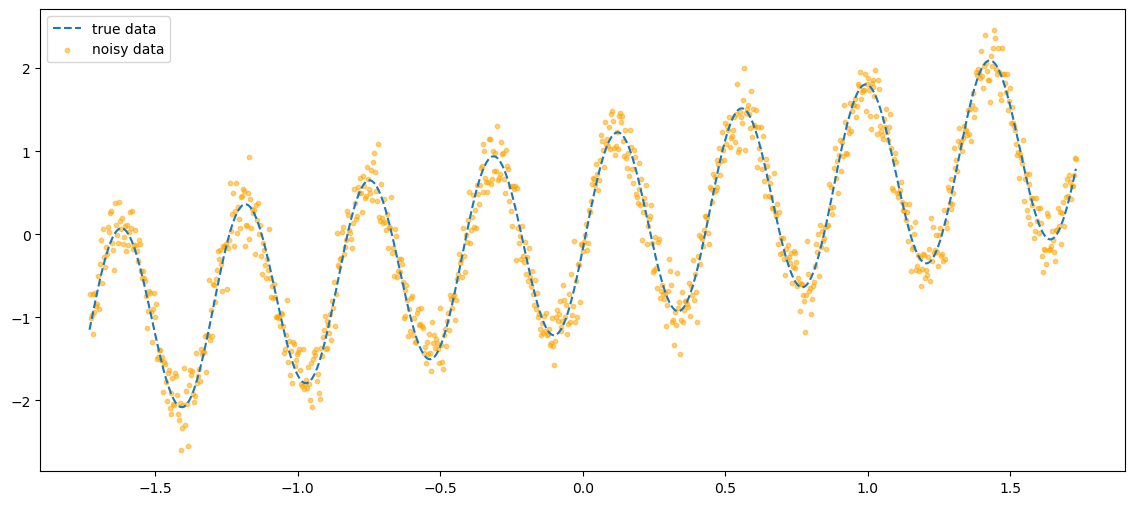

In [62]:
import numpy as np
import torch

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


def info(*tensors, premsg=None, grad=False):
    print('\n')
    if premsg is not None:
        print('###', premsg)
    for tensor in tensors:
        print('-' * 10)
        print('shape:', tensor.shape)
        print('first values:', tensor[:3])
        if grad:
            print('grad:', tensor.grad[:3])


def standardize(tensor):
    return (tensor - tensor.mean()) / tensor.std()


size = 1000

amp = size // 2

X = np.array(np.arange(size), dtype='float64').reshape(-1, 1)
y = (X + amp * np.sin(X * 50 / size)).reshape(-1, 1)

y_obs = y + np.random.normal(0, 100, y.shape)


data_dtype = torch.float32

X = torch.tensor(X, dtype=data_dtype)
y = torch.tensor(y, dtype=data_dtype)
y_obs = torch.tensor(y_obs, dtype=data_dtype)

X = standardize(X)
y = standardize(y)
y_obs = standardize(y_obs)

info(X, y, y_obs)


fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(X, y, linestyle='dashed', label='true data')
ax.scatter(X, y_obs, alpha=0.5, color='orange', s=10, label='noisy data')
ax.legend()
plt.show()

In [67]:
import torch
import math

from more_itertools import flatten


class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        hidden_layers = (
            (torch.nn.Linear(n_hidden_units, n_hidden_units),
             torch.nn.LeakyReLU())
            for _ in range(n_hidden_layers)
        )
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, n_hidden_units),
            torch.nn.LeakyReLU(),
            *flatten(hidden_layers),
            torch.nn.Linear(n_hidden_units, 1)
        )

    def forward(self, x):
        return self.layers(x)


def train(model):
    for t in range(1, n_epochs+1):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)

        # Compute and print loss
        loss = criterion(y_pred, y_obs)
        if t % n_log_interval == 0:
            print(t, loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model


def plot(model):
    with torch.no_grad():
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(X, y, linestyle='dashed', label='true data')
        ax.scatter(X, y_obs, alpha=0.5, color='orange', s=10, label='observed data')
        ax.plot(x, model(x), label='pred', color='red')
        ax.legend()
        plt.show()

3000 0.5855634212493896
6000 0.4092921316623688
9000 0.2576414942741394
12000 0.16480226814746857
15000 0.15407119691371918
18000 0.11087097227573395
21000 0.10902034491300583
24000 0.07265771180391312
27000 0.0805882066488266
30000 0.0685848742723465


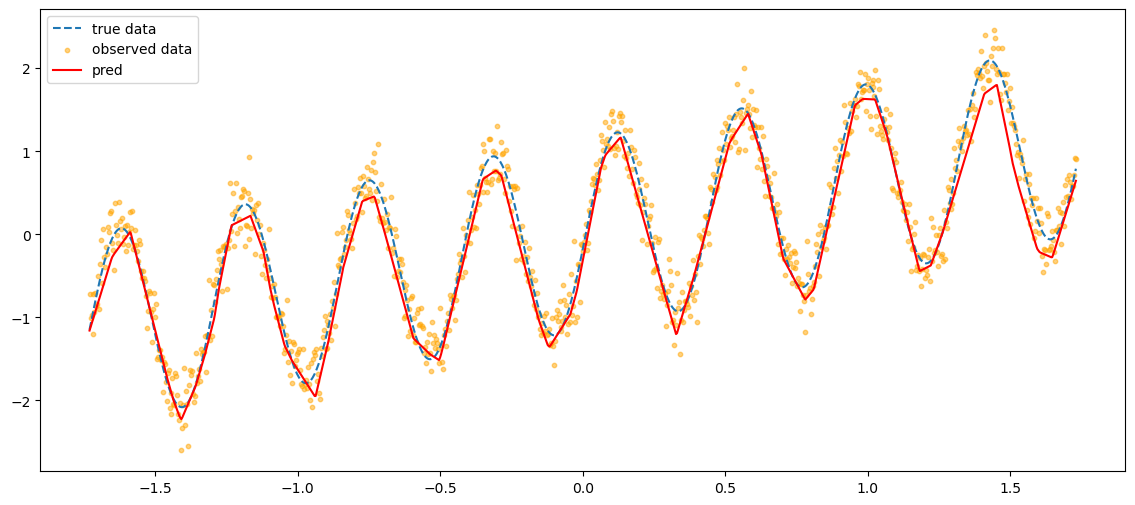

In [76]:
# train and plot

x = X
y = y

n_hidden_layers = 1
n_hidden_units = 50
n_epochs = int(3e4)
n_log_interval = n_epochs // 10
lr = 1e-1

model = MyModel()

criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

model = train(model)
plot(model)